In [1]:
!pip install -U jaxlib[cuda112]==0.3.15 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jax[cuda112]==0.3.17 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install dm-haiku
!pip install tensorflow-probability==0.17
!pip install git+https://github.com/blackjax-devs/blackjax.git
!apt update
!apt install -y graphviz
!apt-get -y install swig
!pip install smac
!pip install graphviz
!pip install gplearn

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 MB 13.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.cudnn82
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.17-py3-none-any.whl size=1217849 sha256=5be9bba26b84ae62326be878a41fbf8864e0e215620001048a3e96a5c0eebe51
  Stored in directory: /root/.cache/pip/wheels/36/cd/88/2d90379f7549c27d5654e893f74210f30f0c645c23a71e6f56
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
  

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 1

In [2]:
if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
# tfd = tfp.distributions
from gibbs_sampler import *

plt.style.use('ggplot')
%load_ext autoreload

In [3]:
if SERVER:
    data_dir = "."
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

### Load Cell Line Data

In [4]:
ccle_samples_df = pd.read_csv(f"{data_dir}/ccle/sample_info.csv", index_col="DepMap_ID")
ccle_samples_df.shape

(1840, 28)

In [5]:
ccle_samples_df

,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,sample_collection_site,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000016,SLR 21,SLR21,SLR21_KIDNEY,NaN,NaN,NaN,Academic lab,CVCL_V607,NaN,kidney,...,NaN,NaN,NaN,NaN,NaN,PT-JnARLB,NaN,Clear cell renal cell carcinoma,C4033,NaN
ACH-000032,MHH-CALL-3,MHHCALL3,MHHCALL3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Female,DSMZ,CVCL_0089,NaN,bone_marrow,...,b_cell,NaN,NaN,NaN,NaN,PT-p2KOyI,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
ACH-000033,NCI-H1819,NCIH1819,NCIH1819_LUNG,NaN,NaN,Female,Academic lab,CVCL_1497,NaN,lymph_node,...,NSCLC_adenocarcinoma,NaN,NaN,NaN,NaN,PT-9p1WQv,NaN,Lung adenocarcinoma,C3512,NaN
ACH-000043,Hs 895.T,HS895T,HS895T_FIBROBLAST,NaN,NaN,Female,ATCC,CVCL_0993,NaN,fibroblast,...,NaN,NaN,2D: adherent,NaN,NaN,PT-rTUVZQ,NaN,Melanoma,C3224,NaN
ACH-000049,HEK TE,HEKTE,HEKTE_KIDNEY,NaN,NaN,NaN,Academic lab,CVCL_WS59,NaN,kidney,...,NaN,NaN,NaN,immortalized,NaN,PT-qWYYgr,NaN,NaN,NaN,No information is available about this cell li...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002393,CRO-AP3,CROAP3,CROAP3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Male,Sanger,CVCL_1810,NaN,ascites,...,b_cell_primary_effusion,NaN,NaN,NaN,NaN,PT-TC0lZM,NaN,Primary effusion lymphoma,C6915,NaN
ACH-002394,GEO,GEO,GEO_LARGE_INTESTINE,NaN,NaN,NaN,Sanger,CVCL_0271,NaN,large_intestine,...,NaN,NaN,NaN,NaN,NaN,PT-Fa1q9q,NaN,Colon carcinoma,C4910,NaN
ACH-002395,HuH-6 Clone 5,HUH6CLONE5,HUH6CLONE5_LIVER,NaN,NaN,Male,Sanger,CVCL_1296,NaN,liver,...,NaN,NaN,NaN,NaN,NaN,PT-TtIXsL,ACH-000671,Hepatoblastoma,C3728,NaN


In [6]:
ccle_samples_df["sample_collection_site"].value_counts()

pleural_effusion                      170
haematopoietic_and_lymphoid_tissue    169
lung                                  145
central_nervous_system                134
lymph_node                            130
ascites                                91
skin                                   84
upper_aerodigestive_tract              71
bone                                   69
soft_tissue                            68
bone_marrow                            63
kidney                                 55
liver                                  54
breast                                 43
large_intestine                        41
ovary                                  41
matched_normal_tissue                  39
fibroblast                             37
endometrium                            36
pancreas                               34
biliary_tract                          34
urinary_tract                          33
oesophagus                             32
Colon                             

In [7]:
ccle_gene_expr_df = pd.read_csv(f"{data_dir}/ccle/CCLE_expression.csv", index_col="DepMap_ID")
ccle_gene_expr_df.shape

(1406, 19221)

In [8]:
ccle_drug_response_df = pd.read_csv(f"{data_dir}/ccle/sanger-dose-response.csv", index_col="DepMap_ID")
ccle_drug_response_gdsc2 = ccle_drug_response_df[ccle_drug_response_df["DATASET"] == "GDSC2"]

In [9]:
ccle_drug_response_gdsc2

,DATASET,COSMIC_ID,DRUG_ID,MIN_CONC,MAX_CONC,RMSE_PUBLISHED,Z_SCORE_PUBLISHED,IC50_PUBLISHED,AUC_PUBLISHED,DRUG_NAME,BROAD_ID,upper_limit,ec50,slope,lower_limit,auc,log2.ic50,mse,R2
DepMap_ID,,,,,,,,,,,,,,,,,,,
ACH-000958,GDSC2,909751,1003,0.000098,0.1,0.126397,-0.765768,0.025129,0.706775,CAMPTOTHECIN,BRD-K37890730,0.961510,1.360365e-02,-1.527913,0.375386,0.790291,-4.963610,0.007940,0.867205
ACH-000651,GDSC2,905962,1003,0.000098,0.1,0.096246,-0.468137,0.049577,0.775083,CAMPTOTHECIN,BRD-K37890730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACH-000856,GDSC2,910927,1003,0.000098,0.1,0.086042,-0.709881,0.028549,0.767213,CAMPTOTHECIN,BRD-K37890730,0.987030,1.051355e-02,-1.267996,0.452929,0.810229,-3.912988,0.003622,0.919492
ACH-000360,GDSC2,908442,1003,0.000098,0.1,0.100553,-0.562205,0.039996,0.730769,CAMPTOTHECIN,BRD-K37890730,0.986668,1.653807e-02,-1.122581,0.394468,0.823684,-3.953616,0.003399,0.927201
ACH-001199,GDSC2,909740,1003,0.000098,0.1,0.080253,1.148459,1.986678,0.921919,CAMPTOTHECIN,BRD-K37890730,0.948195,3.055074e-02,-2.363654,0.822454,0.926233,NaN,0.004085,0.363292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000288,GDSC2,905951,2172,0.009766,10.0,0.143863,0.042524,25.410793,0.877741,JQ1,"BRD-K54606188, NA",3.929045,3.287745e+11,-0.012190,-3.449953,0.856099,NaN,0.006178,0.292447
ACH-001065,GDSC2,906862,2172,0.009766,10.0,0.088631,-2.223819,0.339325,0.510590,JQ1,"BRD-K54606188, NA",0.935866,4.096968e-01,-2.014115,0.176515,0.585800,-1.073816,0.003198,0.971991
ACH-000930,GDSC2,907046,2172,0.009766,10.0,0.114748,-0.578942,7.780877,0.843211,JQ1,"BRD-K54606188, NA",0.960799,3.695946e-01,-1.161533,0.687792,0.830671,NaN,0.002792,0.795935


In [10]:
ccle_drug_response_df["DRUG_NAME"].value_counts()

PLX-4720         2680
AFATINIB         2677
OLAPARIB         2629
GDC-0941         2596
DOCETAXEL        2402
                 ... 
WH-4-023          398
GW843682X         398
ROSCOVITINE       397
JW-7-52-1, NA     386
RIBOCICLIB         47
Name: DRUG_NAME, Length: 397, dtype: int64

In [11]:
drug_target_rel = pd.read_csv(f"{data_dir}/ccle/screened_compounds_rel.csv")
drug_target_rel

,DRUG_ID,SCREENING_SITE,DRUG_NAME,SYNONYMS,TARGET,TARGET_PATHWAY
0,1,MGH,Erlotinib,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",EGFR,EGFR signaling
1,3,MGH,Rapamycin,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",MTORC1,PI3K/MTOR signaling
2,5,MGH,Sunitinib,"Sutent, Sunitinib Malate, SU-11248","PDGFR, KIT, VEGFR, FLT3, RET, CSF1R",RTK signaling
3,6,MGH,PHA-665752,"PHA665752, PHA 665752",MET,RTK signaling
4,9,MGH,MG-132,"LLL cpd, MG 132, MG132","Proteasome, CAPN1",Protein stability and degradation
...,...,...,...,...,...,...
616,2362,SANGER,THR-103,WIMM synthesis,Mutant RAS,PI3K/MTOR signaling
617,2438,SANGER,ascorbate (vitamin C),back-up solution from YWKim,anti-oxidant proteins,Other
618,2439,SANGER,glutathione,"G6013, sigma",anti-oxidant proteins,Other
619,2498,SANGER,alpha-lipoic acid,aLA,Metabolism,Metabolism


### Tamoxifen

In [12]:
target_gene = drug_target_rel[drug_target_rel["DRUG_NAME"] == "Tamoxifen"]["TARGET"].iloc[0]
target_gene

'ESR1'

#### Normalization and Feature Reduction

In [13]:
tamox_response_ccle = ccle_drug_response_gdsc2[ccle_drug_response_gdsc2["DRUG_NAME"] == "TAMOXIFEN"]
tamox_response_ccle.shape

(759, 19)

In [14]:
tamoxifen_ccle_gene_expr = pd.merge(ccle_gene_expr_df, tamox_response_ccle["IC50_PUBLISHED"], left_index=True, right_index=True)
tamoxifen_ccle_gene_expr.shape

(565, 19222)

In [15]:
from sklearn.preprocessing import StandardScaler

seed = 775

X, y = tamoxifen_ccle_gene_expr[tamoxifen_ccle_gene_expr.columns.difference(["IC50_PUBLISHED"])], tamoxifen_ccle_gene_expr["IC50_PUBLISHED"]


In [16]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)

train_df, test_df = pd.concat([X_train_df, y_train_df], axis=1),\
                                     pd.concat([X_test_df, y_test_df], axis=1)

In [17]:
train_scaler = StandardScaler().fit(train_df)
train_scaled = train_scaler.transform(train_df)

# Scale test separately
test_scaler = StandardScaler().fit(test_df)
test_scaled = test_scaler.transform(test_df)

In [18]:
X_train_df, y_train_df = pd.DataFrame(train_scaled[:,:-1], columns=X_train_df.columns), pd.Series(train_scaled[:,-1])
X_test_df, y_test_df = pd.DataFrame(test_scaled[:,:-1], columns=X_test_df.columns), pd.Series(test_scaled[:,-1])
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, random_state=seed, 
                                                        shuffle=True, test_size=0.3)
X_train_df.shape

(316, 19221)

#### Significant Genes

In [19]:
import scipy.stats as stats
def calculate_sig_genes(X, y):

    pvals = np.zeros(X.shape[-1])

    for p in range(X_train_df.shape[-1]):
        _, pval = stats.spearmanr(X.iloc[:, p], y, nan_policy="raise")
        pvals[p] = pval
    
    sig_genes_idx = np.argwhere(pvals< 0.01).ravel()
    sig_genes_idx = np.argsort(pvals)
    return sig_genes_idx

In [20]:
sig_genes_idx = calculate_sig_genes(X_train_df, y_train_df)
sig_genes_idx = sig_genes_idx[:500]

/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [21]:
target_gene_idx = [i for i, col in enumerate(X_train_df.columns) if target_gene in col]
X_train_sig_df = pd.concat([X_train_df.iloc[:,sig_genes_idx], X_train_df.iloc[:,target_gene_idx]], axis=1)
X_val_sig_df = pd.concat([X_val_df.iloc[:,sig_genes_idx], X_val_df.iloc[:,target_gene_idx]], axis=1)
X_test_sig_df = pd.concat([X_test_df.iloc[:,sig_genes_idx], X_test_df.iloc[:,target_gene_idx]], axis=1)

In [22]:
gene_names = [col.split("(")[0].strip() for col in X_train_sig_df.columns]
entrz_ids = [int(col.split("(")[1][:-1].strip()) for col in X_train_sig_df.columns]

### Interaction Data

In [23]:
string_ppi = pd.read_csv(f"{data_dir}/ccle/string_ppi.csv")
string_ppi

,symbolA,symbolB,weight
0,ARF5,ACAP2,0.767
1,ARF5,RAB1A,0.730
2,ARF5,COPE,0.745
3,ARF5,ACAP1,0.765
4,ARF5,COPZ1,0.757
...,...,...,...
474973,EIF3L,EIF3K,0.999
474974,EIF3L,EIF4G1,0.908
474975,EIF3L,EIF3E,0.999
474976,EIF3L,RPL22,0.738


In [24]:
%autoreload
from nn_util import build_network_string
J = build_network_string(gene_names, string_ppi)

In [25]:
np.count_nonzero(J)

1268

In [26]:
rng_key = jax.random.PRNGKey(seed)
X_train_sig, X_val_sig, X_test_sig = X_train_sig_df.to_numpy(), X_val_sig_df.to_numpy(), X_test_sig_df.to_numpy()
y_train, y_test, y_val = y_train_df.to_numpy(), y_test_df.to_numpy(), y_val_df.to_numpy()
X_train_sig, X_test_sig, y_train, y_test = jax.device_put(X_train_sig), jax.device_put(X_test_sig), \
                                   jax.device_put(y_train), jax.device_put(y_test)
X_train_sig.shape                                   

(316, 501)

In [27]:
%autoreload
from operator import itemgetter
from tqdm import tqdm

def evaluate_bnn(model, X, y, params, gammas):
    eval_fn = lambda p, g: model.apply(p, X, g).ravel()
    preds = jax.vmap(eval_fn)(params, gammas)
    preds = preds.reshape(-1, preds.shape[-1])
    losses = jax.vmap(optax.l2_loss, in_axes=(0, None))(preds, y)
    mean_loss = jnp.mean(losses, axis=-1)
    return jnp.sum(mean_loss)

def get_feats_dropout_loss(sgmcmc, X, y):
    var_loss_dict = {"feats_idx": [], "num_models": [] , "loss_on": [], "loss_off": [], "loss_diff": []}
    
    disc_states = mixed_sgmcmc.states_.discrete_position
    contin_states = mixed_sgmcmc.states_.contin_position
    
    

    num_models = disc_states.shape[0]

    p = X.shape[1]

    for idx in range(p):
        # idx = feats_idx[i]
        idx_on = np.argwhere(disc_states[:,idx] == 1.).ravel()
        loss_on, loss_off = 0., 0.
        if idx_on.size == 0: ## irrelevant feature
            loss_diff = 1e9
        else:
            disc_states_on = disc_states[idx_on]
            params_on = jax.tree_util.tree_map(lambda x: x[idx_on], contin_states)
            loss_on = evaluate_bnn(sgmcmc.model_, X, y, params_on, disc_states_on)

            # Turn-off the variable, and see hwo the loss changes
            disc_states_off = disc_states_on.at[:,idx].set(0)
            loss_off = evaluate_bnn(sgmcmc.model_, X, y, params_on, disc_states_off)

            loss_diff = (loss_on - loss_off) * (len(idx_on) / num_models)


        var_loss_dict["feats_idx"].append(idx)
        var_loss_dict["num_models"].append(idx_on.size)
        var_loss_dict["loss_on"].append(loss_on)
        var_loss_dict["loss_off"].append(loss_off)
        var_loss_dict["loss_diff"].append(loss_diff)


    var_loss_df = pd.DataFrame(var_loss_dict).sort_values(by="loss_diff")

    return var_loss_df

def get_gene_names(gene_cols):
    return [gene.split("(")[0].strip() for gene in gene_cols]

### BNN

In [28]:
%autoreload
from smac.facade.smac_mf_facade import SMAC4MF
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.scenario.scenario import Scenario
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
from sgmcmc_cyclical_bkp import MixedSGMCMC
from run_nn_fisher_test_exp import run_logistic_regression
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import (
    CategoricalHyperparameter,
    UniformFloatHyperparameter,
    UniformIntegerHyperparameter,
)

from ConfigSpace import InCondition, Configuration

import math

def get_configspace(input_size)-> ConfigurationSpace:
    # Build Configuration Space which defines all parameters and their ranges.

    layer_dims = [50, 100, 150, 200, 250, 300, 350]

    cs  = ConfigurationSpace()

    # layer_dim = CategoricalHyperparameter("layer_dim", layer_dims, default_value=layer_dims[0])
    # activation = CategoricalHyperparameter("activation", ["relu", "tanh"], default_value="tanh")
    
    # disc_lr = CategoricalHyperparameter("disc_lr", [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5] , default_value=1e-1)
    # contin_lr = CategoricalHyperparameter("contin_lr", [1e-5, 1e-4, 1e-3, 1e-2], default_value=1e-5) #TODO Extend range

    # lr_schedule = CategoricalHyperparameter("lr_schedule", ["cyclical"], default_value="cyclical")
    # num_cycles = CategoricalHyperparameter("num_cycles", [3, 4, 5, 7], default_value=5)
    # beta = CategoricalHyperparameter("beta", [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], default_value=0.9)

    # batch_size = CategoricalHyperparameter("batch_size", [16, 32, 64, 128], default_value=32)
    # thinning_interval = CategoricalHyperparameter("thinning_interval", [10, 50, 100, 150, 200], default_value=100)

    # eta = CategoricalHyperparameter("eta", [0.01, 0.1, 1., 5, 10., 50., 100.], default_value=1.)
    mu = CategoricalHyperparameter("mu", [0.01, 0.1, 1., 5, 10., 50., 100.], default_value=1.)
    # temp = CategoricalHyperparameter("temp", [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1.], default_value=1.)
    # sigma = CategoricalHyperparameter("sigma", [1e-3, 1e-2, 1e-1, 0.5, 1., 10.], default_value=1.)


    # Add hyper-parameters
    # cs.add_hyperparameters([layer_dim, activation, disc_lr, contin_lr, eta, mu, temp, sigma, num_cycles, beta])
    cs.add_hyperparameters([mu])

    # # Cyclical SG-MCMC condition
    # use_cycle_len = InCondition(child=cycle_len, parent=lr_schedule, values=["cyclical"])
    # use_beta = InCondition(child=beta, parent=lr_schedule, values=["cyclical"])
    #
    # cs.add_conditions([use_cycle_len, use_beta])

    return cs

def get_cv_score(model, X, y, cv, activation_fns, J):

    scores = []

    for train_idx, test_idx in cv.split(X, y):
        x_train_cv, y_train_cv = X[train_idx], y[train_idx]
        x_test_cv, y_test_cv = X[test_idx], y[test_idx]
        model.fit(x_train_cv, y_train_cv, activation_fns=activation_fns, J=J)
        score = jax.device_get(model.score(x_test_cv, y_test_cv))
        scores.append(score)
    
    mean_score = np.mean(np.array(scores))
    if math.isnan(mean_score):
        return -1e9
    
    return mean_score

def generate_train_cs(seed, X, y, J):
    cv = KFold(n_splits=3, shuffle=True, random_state=seed)
    # X_tr, X_val, y_tr, y_val = train_test_split(X, y, stratify=y, test_size=0.1, shuffle=seed)
    def train_cs(config: Configuration)-> float:

        # params = {"disc_lr":config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": 20,
        #           "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
        #           "sigma": config["sigma"], "beta": config["beta"], "num_cycles": config["num_cycles"]}

        params = {"disc_lr": 0.1, "contin_lr": 1e-5, "batch_size": 20,
                  "mu": config["mu"], "eta": 1.0, "temp": 1.0,
                  "sigma": 1.0, "beta": 0.95, "num_cycles": 5}

        # print(config)
        mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=100, n_warmup=0, lr_schedule="cyclical",
                            n_chains=1, layer_dims=[300, 100], classifier=False ,**params)

        score = get_cv_score(mixed_sgmcmc, X, y, cv, ["tanh", "tanh"], J)
        # print(score)
        return 1 - score


    return train_cs


def optimize_hyper_parameters(seed, X, y, J, total_time=60):
    cs = get_configspace(X.shape[1])
    scenario = Scenario({
        "run_obj": "quality",
        "wallclock-limit": total_time,
        "cs": cs,
        "deterministic": True,
        "cutoff": 10,  # runtime limit for the target algorithm
        "verbose_level": "DEBUG", 
        "seed": seed
    })

    max_steps = 5000

    train_cs = generate_train_cs(seed, X, y, J)

    intensifier_kwargs = {"initial_budget": 2000, "max_budget": max_steps}

    # smac = SMAC4MF(scenario=scenario, rng=np.random.RandomState(seed),
    #                tae_runner=train_cs, intensifier_kwargs=intensifier_kwargs)

    smac = SMAC4HPO(scenario=scenario, rng=np.random.RandomState(seed), tae_runner=train_cs)

    tae = smac.get_tae_runner()

    try:
        incumbent = smac.optimize()

    finally:
        incumbent = smac.solver.incumbent


    inc_val = tae.run(config=incumbent, budget=max_steps, seed=seed)

    return incumbent, 1 - inc_val[1], smac


In [29]:
# config, score, smac = optimize_hyper_parameters(seed, X_train_sig, y_train, J, total_time=180)
# score

In [30]:
config = {
  'activation': 'tanh',
  'beta': 0.95,
  'contin_lr': 1e-05,
  'disc_lr': 0.1,
  'eta': 1.0,
  'layer_dim': [300, 100, 100],
  'activation_fns': ["tanh", "tanh", "tanh"],
  'mu': 1.0,
  'num_cycles': 5,
  'sigma': 1.0,
  'temp': 1.0,
}

In [31]:
X_train_sig.shape

(316, 501)

In [32]:
%autoreload
from sgmcmc_cyclical_bkp import MixedSGMCMC
from sklearn.metrics import r2_score
cv = KFold(n_splits=3, shuffle=True, random_state=seed)
params = {"disc_lr":config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": 32,
                  "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
                  "sigma": config["sigma"], "beta": config["beta"], "num_cycles": config["num_cycles"]}

mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=200, n_warmup=0, lr_schedule="cyclical",
                            layer_dims=config["layer_dim"], classifier=False ,**params)

# cv_score_bnn = get_cv_score(mixed_sgmcmc, X_train_sig, y_train, cv, config["activation_fns"], J)
# print(cv_score_bnn)
mixed_sgmcmc.fit(X_train_sig, y_train, activation_fns=config["activation_fns"] , J=J)
n_models = mixed_sgmcmc.states_.discrete_position.shape[0]
print(f"Num models: {n_models}")
print(f"val_score: {mixed_sgmcmc.score(X_val_sig, y_val)}, test_score: {mixed_sgmcmc.score(X_test_sig, y_test)}")

Num batches: 10
Num models: 100
val_score: 0.009575087979897257, test_score: 0.016237003474307676


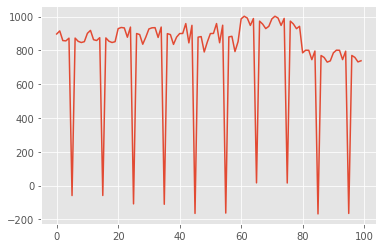

In [33]:
plt.plot(mixed_sgmcmc.states_.disc_logprob.ravel())

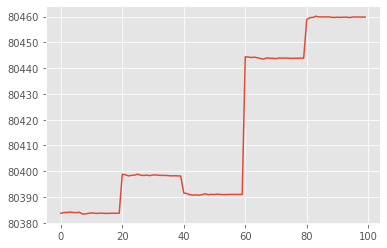

In [393]:
# plt.plot(mixed_sgmcmc.states_.disc_logprob.ravel())
plt.plot(mixed_sgmcmc.states_.contin_logprob.ravel())

In [394]:
per_cycle_contin_pos = jax.tree_util.tree_map(lambda x: x.reshape((mixed_sgmcmc.num_cycles, -1) +  x.shape[1:]), mixed_sgmcmc.states_.contin_position)
per_cycle_disc_pos = mixed_sgmcmc.states_.discrete_position.reshape(mixed_sgmcmc.num_cycles, -1,
                                            mixed_sgmcmc.states_.discrete_position.shape[-1])                                        

In [395]:
pred_fn = lambda p, g: mixed_sgmcmc.model_.apply(p, X_test_sig, g).ravel()
per_cycle_pred = jnp.mean(jax.vmap(jax.vmap(pred_fn))(per_cycle_contin_pos, per_cycle_disc_pos), axis=1)

In [396]:
%autoreload
from gibbs_sampler_cyclical_bkp import make_gaussian_likelihood
log_ll_fn = make_gaussian_likelihood(mixed_sgmcmc.sigma, mixed_sgmcmc.temp, X_train_sig.shape[0])

per_cycle_ll = jax.vmap(jax.vmap(lambda p, g: log_ll_fn(mixed_sgmcmc.model_, p, [X_train_sig[:20], y_train[:20]], g)))(per_cycle_contin_pos, per_cycle_disc_pos)

harmonic_mean = 1./(jnp.mean((1./per_cycle_ll), axis=-1))

In [397]:
jnp.mean(per_cycle_ll, axis=-1)

DeviceArray([250.21011, 252.91325, 249.59021, 251.23502, 243.86058], dtype=float32)

In [398]:
jnp.mean((y_test - per_cycle_pred[1])**2)

DeviceArray(0.953219, dtype=float32)

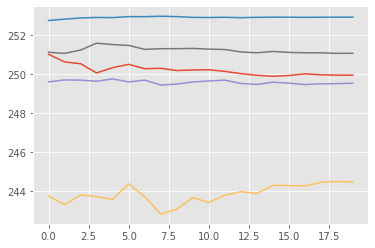

In [399]:
for i in range(mixed_sgmcmc.num_cycles):
    plt.plot(per_cycle_ll[i])

In [400]:
dropout_loss = get_feats_dropout_loss(mixed_sgmcmc, X_train_sig, y_train)
dropout_loss

,feats_idx,num_models,loss_on,loss_off,loss_diff
51,51,100,55.801952,55.830696,-0.028743744
78,78,100,55.801952,55.8303,-0.028347015
421,421,100,55.801952,55.829483,-0.02753067
26,26,100,55.801952,55.82834,-0.026386261
152,152,100,55.801952,55.826576,-0.02462387
...,...,...,...,...,...
423,423,0,0.0,0.0,1000000000.0
275,275,0,0.0,0.0,1000000000.0
199,199,0,0.0,0.0,1000000000.0
286,286,0,0.0,0.0,1000000000.0


In [401]:
bnn_feat_idx = dropout_loss["feats_idx"][:20].to_list()
bnn_gene_list = X_train_sig_df.iloc[:,bnn_feat_idx].columns.to_list()
bnn_gene_list = get_gene_names(bnn_gene_list)
bnn_gene_list

['NTN4',
 'THBS1',
 'TGFB2',
 'CLCF1',
 'SEMA3B',
 'RHEB',
 'ITGB1',
 'ALDH1A3',
 'CHMP4B',
 'BFSP1',
 'PPARG',
 'FLNB',
 'PLXNB3',
 'CREB3',
 'PDK4',
 'ERRFI1',
 'KRT7',
 'ARHGAP9',
 'TMSB10',
 'PPL']

In [402]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf_reg = RandomForestRegressor(random_state=seed, max_samples=0.9)
grid_cv = GridSearchCV(estimator = rf_reg, param_grid = param_grid, 
                          cv = cv, n_jobs = -1, verbose = 1, scoring="explained_variance").fit(X_train_sig, y_train)

rf_reg = RandomForestRegressor(random_state=seed, max_samples=0.9,**grid_cv.best_params_)
rf_reg.fit(X_train_sig, y_train)
y_test_pred_rf = rf_reg.predict(X_test_sig)
print(f"RF params: {grid_cv.best_params_}")
print(f"cv score: {grid_cv.best_score_}, test_score:  {r2_score(y_test, y_test_pred_rf)}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits
RF params: {'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
cv score: 0.09994573483334172, test_score:  0.12622832816763363


In [403]:
stats.pearsonr(y_test, rf_reg.predict(X_test_sig))

(0.4101100067585304, 6.4480939164351866e-06)

In [404]:
rf_feat_idx = np.argsort(rf_reg.feature_importances_)[::-1][:20]
rf_gene_list = X_train_sig_df.iloc[:,rf_feat_idx].columns.to_list()
rf_gene_list = get_gene_names(rf_gene_list)
rf_gene_list

['PPDPF',
 'QRSL1',
 'CLDN4',
 'TRNP1',
 'SECTM1',
 'YAP1',
 'RBPMS',
 'ZNF185',
 'ZSCAN32',
 'KISS1',
 'MTF2',
 'ITGB6',
 'KRT15',
 'ENC1',
 'RFX7',
 'ERBB2',
 'DYNLRB1',
 'CRLF3',
 'KDELR2',
 'PLEKHA6']

### GP

In [38]:
from gplearn.genetic import SymbolicTransformer, SymbolicClassifier, SymbolicRegressor
from gplearn.functions import make_function
import operator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

def get_best_programs(gp, num_models, classifier=True, ascending=True, sort_fit="OOB_fitness"):
    gp_dict = {'Gen': [], "Ind": [], "Fitness": [], 'OOB_fitness': [], "Equation": []}

    if classifier:
        for idGen in range(len(gp._programs)):
            for idPopulation in range(gp.population_size):
                gp_dict["Gen"].append(idGen)
                gp_dict["Ind"].append(idPopulation)
                gp_dict["Fitness"].append(gp._programs[idGen][idPopulation].fitness_)
                gp_dict["OOB_fitness"].append(gp._programs[idGen][idPopulation].oob_fitness_)
                gp_dict["Equation"].append(str(gp._programs[idGen][idPopulation]))
    else:
        for idx, prog in enumerate(gp._programs[-1]):
                gp_dict["Gen"].append(-1)
                gp_dict["Ind"].append(idx)
                gp_dict["Fitness"].append(prog.fitness_)
                gp_dict["OOB_fitness"].append(prog.oob_fitness_)
                gp_dict["Equation"].append(str(prog))

    gp_df = pd.DataFrame(gp_dict).sort_values(sort_fit, ascending=ascending)[:num_models]
    programs = []
    for i in range(num_models):
        gen, ind = int(gp_df.iloc[i]["Gen"]), int(gp_df.iloc[i]["Ind"])
        programs.append(gp._programs[gen][ind])

    return programs, gp_df


def gp_transform(est, X, classifier=False, num_models=100, sort_fit="Fitness"):
    if classifier or (sort_fit == "OOB_fitness"):
        programs, gp_df = get_best_programs(est, num_models, classifier, sort_fit=sort_fit, ascending=classifier)
        out = np.zeros((X.shape[0], len(programs)))
        for i, prog in enumerate(programs):
            out[:, i] = prog.execute(X)

        return out, gp_df
    else:
        return est.transform(X), None

function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min']

def train_gp(feats_idx, X_train, X_val, X_test, y_train, y_val, y_test, num_models=5, sort_fit="OOB_fitness"):
    X_gp_train, X_gp_val, X_gp_test = X_val[:,feats_idx], X_train[:,feats_idx], X_test[:,feats_idx]
    gp_est = SymbolicTransformer(population_size=1000, hall_of_fame=100, n_components=20, generations=100,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.8, verbose=0,
                           parsimony_coefficient=0.005, random_state=seed)

    gp_est.fit(X_gp_train, y_val)
    gp_features_val, gp_val_df = gp_transform(gp_est, X_gp_val, classifier=False, sort_fit=sort_fit, num_models=num_models)
    gp_features_test, gp_test_df = gp_transform(gp_est, X_gp_test, classifier=False, sort_fit=sort_fit, num_models=num_models)

    X_val_comb, X_test_comb = np.concatenate([X_gp_val, gp_features_val], axis=1),\
                             np.concatenate([X_gp_test, gp_features_test], axis=1)

    param_grid = {"alpha":np.logspace(-2, 2, 20)}
    grid_cv = GridSearchCV(estimator=Ridge(max_iter=10000), param_grid=param_grid, 
                                            verbose=0, scoring="explained_variance", cv=cv).fit(X_val_comb, y_train)
    lin_model = Ridge(max_iter=10000, **grid_cv.best_params_)
    cv_score = grid_cv.best_score_
    lin_model.fit(X_val_comb, y_train)
    y_test_pred = lin_model.predict(X_test_comb)
    test_score = r2_score(y_test, y_test_pred)
    test_pearson, pval = stats.pearsonr(y_test, y_test_pred)
    return cv_score, test_score, test_pearson, pval

#### BNN Selected Features

In [405]:
cv_score, test_score, test_pc, pc_pval = train_gp(bnn_feat_idx, X_train_sig, X_val_sig, X_test_sig, 
                                                    y_train, y_val, y_test)

print(f"cv_score: {cv_score}, test_score: {test_score},\nPearson Corr: {test_pc}, pvalue: {pc_pval}")

cv_score: -0.26129580264621416, test_score: 0.06379045714454878,
Pearson Corr: 0.2620345089474272, pvalue: 0.005052642903002101


#### RF Selected Features

In [406]:
cv_score, test_score, test_pc, pc_pval = train_gp(rf_feat_idx, X_train_sig, X_val_sig, X_test_sig, 
                                                    y_train, y_val, y_test, num_models=1)

print(f"cv_score: {cv_score}, test_score: {test_score},\nPearson Corr: {test_pc}, pvalue: {pc_pval}")

cv_score: 0.039998300252101125, test_score: 0.10149977385374487,
Pearson Corr: 0.3226245852860006, pvalue: 0.0004919711794789678


### Multiple Runs

In [376]:
200*(X_train_sig.shape[0] // 100 + 1)

800

In [35]:
# seeds = [422,261,968,282,739]
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]

In [45]:
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
import pickle 
from datetime import timedelta
import time

save_dir = f"{data_dir}/exp_data_5/cancer/ccle"

bnn_exp_dict = {"seed": [], "model": [], "cv_score": [], "test_score": []}
bnn_gp_dict = {"seed": [], "model": [], "num_feats": [], "n_models": [], "cv_score": [], "test_score": [], "test_pearson": [], "pvalue": []}

num_feats = 20 # TODO this should be selected by CV
n_models = 5 # TODO this should be selected by CV

for seed in seeds:
    print(f"Running seed: {seed}")

    start = time.time()

    cv = KFold(n_splits=5, shuffle=True, random_state=seed)

    ## TODO Wrap this in a function
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)
    
    train_df, test_df = pd.concat([X_train_df, y_train_df], axis=1),\
                                     pd.concat([X_test_df, y_test_df], axis=1)


    train_scaler = StandardScaler().fit(train_df)
    train_scaled = train_scaler.transform(train_df)

    test_scaler = StandardScaler().fit(test_df)
    test_scaled = test_scaler.transform(test_df)

    X_train_df, y_train_df = pd.DataFrame(train_scaled[:,:-1], columns=X_train_df.columns), pd.Series(train_scaled[:,-1])
    X_test_df, y_test_df = pd.DataFrame(test_scaled[:,:-1], columns=X_test_df.columns), pd.Series(test_scaled[:,-1])

    X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, random_state=seed, 
                                                        shuffle=True, test_size=0.3)

    sig_genes_idx = calculate_sig_genes(X_train_df, y_train_df)
    sig_genes_idx = sig_genes_idx[:500]

    target_gene_idx = [i for i, col in enumerate(X_train_df.columns) if target_gene in col]
    X_train_sig_df = pd.concat([X_train_df.iloc[:,sig_genes_idx], X_train_df.iloc[:,target_gene_idx]], axis=1)
    X_val_sig_df = pd.concat([X_val_df.iloc[:,sig_genes_idx], X_val_df.iloc[:,target_gene_idx]], axis=1)
    X_test_sig_df = pd.concat([X_test_df.iloc[:,sig_genes_idx], X_test_df.iloc[:,target_gene_idx]], axis=1)

    gene_names = [col.split("(")[0].strip() for col in X_train_sig_df.columns]
   
    J = build_network_string(gene_names, string_ppi)

    X_train_sig, X_val_sig, X_test_sig = X_train_sig_df.to_numpy(), X_val_sig_df.to_numpy(), X_test_sig_df.to_numpy()
    y_train, y_test, y_val = y_train_df.to_numpy(), y_test_df.to_numpy(), y_val_df.to_numpy()
    X_train_sig, X_test_sig, y_train, y_test = jax.device_put(X_train_sig), jax.device_put(X_test_sig), \
                                    jax.device_put(y_train), jax.device_put(y_test)

    param_grid = {
        'bootstrap': [True],
        'max_depth': [80, 90, 100, 110],
        'max_features': [2, 3],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 200, 300, 1000]
    }

    rf_reg = RandomForestRegressor(random_state=seed, max_samples=0.9)
    grid_cv = GridSearchCV(estimator = rf_reg, param_grid = param_grid, 
                            cv = cv, n_jobs = -1, verbose = 0, scoring="explained_variance").fit(X_train_sig, y_train)

    rf_reg = RandomForestRegressor(random_state=seed, max_samples=0.9, **grid_cv.best_params_)
    rf_reg.fit(X_train_sig, y_train)
    rf_val_score = r2_score(y_val, rf_reg.predict(X_val_sig))
    rf_test_score = r2_score(y_test,  rf_reg.predict(X_test_sig))

    # config, bnn_cv_score, _ = optimize_hyper_parameters(seed, X_train_sig, y_train, J, total_time=180)
    # config = pickle.load(open(f"{save_dir_100}/bnn_params_s_{seed}.pickle", "rb"))

    params = {"disc_lr":config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": X_train_sig.shape[0],
                    "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
                    "sigma": config["sigma"], "beta": config["beta"], "num_cycles": config["num_cycles"]}

    mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=1000, n_warmup=0, lr_schedule="cyclical",
                            layer_dims=config["layer_dim"], classifier=False ,**params)

    mixed_sgmcmc.fit(X_train_sig, y_train, activation_fns=config["activation_fns"] , J=J)

    bnn_val_score = mixed_sgmcmc.score(X_val_sig, y_val)
    bnn_test_score = mixed_sgmcmc.score(X_test_sig, y_test)

    dropout_loss = get_feats_dropout_loss(mixed_sgmcmc, X_train_sig, y_train)
    dropout_loss.to_csv(f"{save_dir}/drop_out_loss_s_{seed}.csv", index=False)


    bnn_exp_dict["seed"].append(seed)
    bnn_exp_dict["model"].append("RF")
    bnn_exp_dict["cv_score"].append(rf_val_score)
    bnn_exp_dict["test_score"].append(rf_test_score)

    bnn_exp_dict["seed"].append(seed)
    bnn_exp_dict["model"].append("BNN")
    bnn_exp_dict["cv_score"].append(bnn_val_score)
    bnn_exp_dict["test_score"].append(bnn_test_score)
    

    
    print(f"RF cv_score: {rf_val_score}, RF test_score: {rf_test_score}")
    print(f"BNN cv_score: {bnn_val_score}, BNN test_score: {bnn_test_score}")
    print("=================== GP Train ======================")

    bnn_feat_idx = dropout_loss["feats_idx"][:num_feats].to_list()
    rf_feat_idx = np.argsort(rf_reg.feature_importances_)[::-1][:num_feats]
    bnn_gp_cv_score, bnn_gp_test_score, bnn_gp_test_pc, bnn_gp_pc_pval = train_gp(bnn_feat_idx, X_train_sig, X_val_sig, X_test_sig, 
                                                                                    y_train, y_val, y_test, num_models=n_models)

    rf_gp_cv_score, rf_gp_test_score, rf_gp_test_pc, rf_gp_pc_pval = train_gp(rf_feat_idx, X_train_sig, X_val_sig, X_test_sig, 
                                                                                    y_train, y_val, y_test, num_models=n_models)
    bnn_gp_dict["seed"].append(seed)
    bnn_gp_dict["model"].append("RF")
    bnn_gp_dict["num_feats"].append(num_feats)
    bnn_gp_dict["n_models"].append(n_models)
    bnn_gp_dict["cv_score"].append(rf_gp_cv_score)
    bnn_gp_dict["test_score"].append(rf_gp_test_score)
    bnn_gp_dict["test_pearson"].append(rf_gp_test_pc)
    bnn_gp_dict["pvalue"].append(rf_gp_pc_pval)

    bnn_gp_dict["seed"].append(seed)
    bnn_gp_dict["model"].append("BNN")
    bnn_gp_dict["num_feats"].append(num_feats)
    bnn_gp_dict["n_models"].append(n_models)
    bnn_gp_dict["cv_score"].append(bnn_gp_cv_score)
    bnn_gp_dict["test_score"].append(bnn_gp_test_score)
    bnn_gp_dict["test_pearson"].append(bnn_gp_test_pc)
    bnn_gp_dict["pvalue"].append(bnn_gp_pc_pval)

    end = time.time()
    elapsed = timedelta(seconds=(end - start))

    print(f"BNN GP - cv_score: {bnn_gp_cv_score}, test_score: {bnn_gp_test_score}, Pearson Corr: {bnn_gp_test_pc}, pvalue: {bnn_gp_pc_pval}")
    print(f"RF GP - cv_score: {rf_gp_cv_score}, test_score: {rf_gp_test_score}, Pearson Corr: {rf_gp_test_pc}, pvalue: {rf_gp_pc_pval}")
    print(f"Done - seed {seed}, Elpased time: {elapsed}")
    print("============================")

bnn_exp_df = pd.DataFrame(bnn_exp_dict)
bnn_exp_df.to_csv(f"{save_dir}/res_bnn_exp_summary.csv", index=False)
bnn_gp_df = pd.DataFrame(bnn_gp_dict)
bnn_gp_df.to_csv(f"{save_dir}/res_bnn_gp_summary.csv", index=False)

Running seed: 422
Num batches: 1
RF cv_score: 0.07444513100837169, RF test_score: 0.14340958099649903
BNN cv_score: 0.0599629999893182, BNN test_score: 0.037209186513402326
=================== GP Train ======================
BNN GP - cv_score: -762814.9384089592, test_score: 0.10361713477759493, Pearson Corr: 0.341391029624674, pvalue: 0.00021517128467983174
RF GP - cv_score: -0.30814202885863556, test_score: 0.12099939913504965, Pearson Corr: 0.3495700529689586, pvalue: 0.0001475716901833638
Done - seed 422, Elpased time: 0:07:08.841668
Running seed: 261
Num batches: 1
RF cv_score: 0.11352835269504746, RF test_score: 0.11687619049433673
BNN cv_score: 0.06888662099841347, BNN test_score: 0.06219921897506875
=================== GP Train ======================
BNN GP - cv_score: -0.30033042567308554, test_score: 0.08642848042291362, Pearson Corr: 0.2977402149941772, pvalue: 0.0013610093826806715
RF GP - cv_score: -0.13186501374314913, test_score: 0.08880894418216034, Pearson Corr: 0.3038

: 

In [42]:
bnn_exp_df.groupby(["model"]).mean()

,seed,cv_score,test_score
model,,,
BNN,494.15,0.013462,0.015567
RF,494.15,0.070922,0.080446


In [44]:
bnn_gp_df.groupby(["model"])["cv_score", "test_score", "test_pearson"].mean()

,cv_score,test_score,test_pearson
model,,,
BNN,-4.459203,-7.843861,0.197971
RF,-55.886796,-0.560879,0.160347


In [ ]:
import torch
from itertools import product

data_dim, num_cls = 2, 3

zeros_mat = torch.zeros((1, data_dim, num_cls)) 

classes = [i for i in range(num_cls)]
probs = []
combos = list(product(classes, repeat=data_dim))

In [50]:
combos

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [48]:
rand_mat = torch.rand_like(zeros_mat)
rand_mat

tensor([[[0.9672, 0.6902, 0.1459],
         [0.0576, 0.8922, 0.0325]]])

In [51]:
rand_mat[:, :, combos[1]]

tensor([[[0.9672, 0.6902],
         [0.0576, 0.8922]]])

In [85]:
dist = tfd.Categorical(probs=[[0.1, 0.5, 0.4], [0.1, 0.5, 0.4]])
x_cur  = dist.sample(seed=rng_key, sample_shape=(2,))
x_cur

DeviceArray([[1, 2],
             [1, 1]], dtype=int32)

In [86]:
x_cur_oh = jax.nn.one_hot(x_cur, 3)
x_cur_oh.shape

(2, 2, 3)

In [87]:
grad = jax.random.normal(rng_key, x_cur_oh.shape)
grad

DeviceArray([[[ 0.3708746 , -1.1752596 , -0.51433975],
              [ 1.9475722 , -1.298365  , -0.61030054]],

             [[ 0.5575748 ,  0.10283418, -0.8314232 ],
              [-0.37285715, -0.54886764, -0.5990561 ]]], dtype=float32)

In [84]:
grad.shape

(1, 2, 3)

In [91]:
grad_cur = grad[0, :, x_cur[0, :]]
grad_cur

DeviceArray([[-1.1752596 , -1.298365  ],
             [-0.51433975, -0.61030054]], dtype=float32)

In [94]:
grad_cur.shape

(2, 2)

In [105]:
jnp.tile(grad_cur[:,:,None], (1, 1, 2))

DeviceArray([[[-1.1752596 , -1.1752596 ],
              [-1.298365  , -1.298365  ]],

             [[-0.51433975, -0.51433975],
              [-0.61030054, -0.61030054]]], dtype=float32)

In [89]:
grad[1, :, x_cur[1, :]]

DeviceArray([[ 0.10283418, -0.54886764],
             [ 0.10283418, -0.54886764]], dtype=float32)

In [88]:
x_cur[1, :]

DeviceArray([1, 1], dtype=int32)